This notebook is the result of __Ludovic Sterlin and Remi Grand__ work on 2020 exam of the class "FSD311-SDD-AML-Lin", given by Mr RISSER

# EXAMEN 2020
Cet examen est composé de deux exercices. 

Les réponses seront données dans un notebook et l'examen sera fait soit seul soit en binome. 

In [302]:
# make general imports
import pandas as pd
import numpy as np
import math  
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex, clear_output
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from scipy import stats
from scipy.optimize import minimize
from statistics import mean
from collections import Counter


# Exercice 1 : 
Nous souhaitons maintenant evaluer si un nouveau traitement à un effet significatif sur l'__efficacite__ d'un moteur en fonction de son __age__.

## QUESTION 1.1 : 
Lisez le fichier `Observations_2.csv` qui contient les donnees, traitez les et representez les avec :
- 'Age' en abscisse
- 'Efficiency' en ordonnee
- Les observations avec le traitement standard (Standard) en bleu
- Les observations avec le nouveau traitement (Tested) en rouge.

A la vue du graphe, vous semble-t-il y avoir un effet ?

In [303]:
# Reading of the csv file
dataframe2=pd.read_csv("./data/Observations_2.csv",sep=' ')
dataframe2.head(1)

,Treatment,Age,Efficiency
0,Standard,3.9479,3.2224


In [32]:
dataframe2.describe()

,Age,Efficiency
count,70.000000,70.000000
mean,5.095016,3.882837
std,2.837539,1.320810
min,0.402640,1.099200
25%,2.718500,3.238025
50%,4.891650,3.867900
75%,7.603675,4.748475
max,9.974900,6.731900


In [33]:
# General statistics on each group of data
dataframe2.groupby("Treatment").describe()

Age                                                           \
          count      mean       std      min      25%      50%       75%   
Treatment                                                                  
Standard   50.0  5.285968  2.745240  0.40264  3.45875  5.53165  7.627775   
Tested     20.0  4.617638  3.077085  0.80066  2.07540  3.75350  6.873100   

                  Efficiency                                                 \
              max      count      mean       std     min       25%      50%   
Treatment                                                                     
Standard   9.8588       50.0  3.749378  1.397119  1.0992  2.766100  3.79060   
Tested     9.9749       20.0  4.216485  1.066503  2.1778  3.645375  4.03055   

                             
                75%     max  
Treatment                    
Standard   4.748475  5.9266  
Tested     4.717200  6.7319

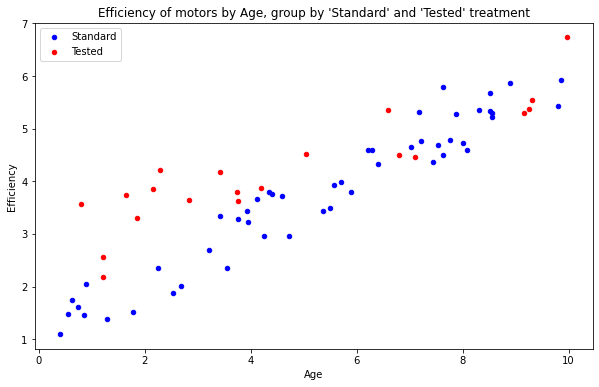

In [34]:
# Plot the observations representing Efficiency of motors by Age, group by 'Standard' and 'Tested' treatment
fig, ax = plt.subplots(figsize=(10,6))
for key, group in dataframe2.groupby("Treatment"):
    group.plot(ax=ax, kind='scatter', x='Age',y='Efficiency', 
    title="Efficiency of motors by Age, group by 'Standard' and 'Tested' treatment", label=key, 
    color='r' if key=='Tested' else 'b')
plt.show()

### A la vue du graphe, vous semble-t-il y avoir un effet ?
En observant le graphique nous pouvons suggérer que le nouveau traitement rend les moteurs plus efficaces lors de leurs premières années d'utilistation, nottament de facon sigificative pendant les 5 premières années. 

Cependant il semble aussi provoquer une détérioration prématurée du moteur comparé au traitement standard, en effet on peut voir qu'en moyenne la tendance de l'efficacité à croître avec l'âge est plus faible pour le nouveau traitement que pour le standard.

Il faut tout de même rester prudent car nous avons peu de données surtout sur le nouveau traitement ("Tested"), uniquement 20 points de données comparé à 50 pour le traitement standard ("Standard").

## QUESTION 1.2 : 
On supposera qu'il existe une relation lineaire entre l'age du moteur et son niveau d'efficacite a un bruit Gaussien pres. Utilisez un modele de type regression lineaire pour mettre en lien les données. 

Utilisez ensuite un test statistique pour evaluer si l'impact du traitement est significatif.

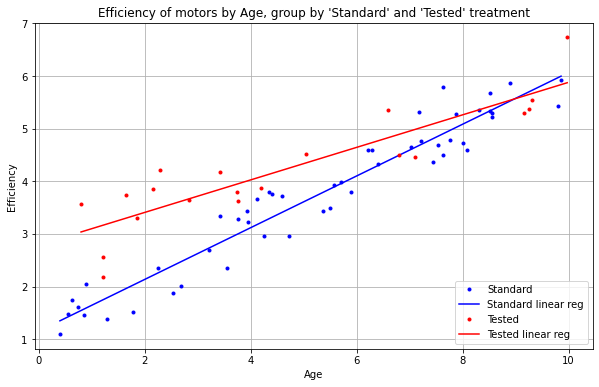

In [35]:
# Seperating data in two dataframe
Standard = dataframe2.loc[dataframe2["Treatment"] == "Standard"].sort_values(by='Age')
Tested = dataframe2.loc[dataframe2["Treatment"] == "Tested"].sort_values(by='Age')

# making linear regression on each one of them
lrs = LinearRegression()
lrs.fit(Standard.Age[:, np.newaxis], Standard.Efficiency)

lrt = LinearRegression()
lrt.fit(Tested.Age[:, np.newaxis], Tested.Efficiency)

# Plotting the data in one same graph
fig = plt.figure(figsize=(10,6))

plt.plot(Standard.Age, Standard.Efficiency, 'b.')
plt.plot(Standard.Age, lrs.predict(Standard.Age[:, np.newaxis]), 'b-')

plt.plot(Tested.Age, Tested.Efficiency, 'r.')
plt.plot(Tested.Age, lrt.predict(Tested.Age[:, np.newaxis]), 'r-')

plt.xlabel('Age')
plt.ylabel('Efficiency')
plt.legend(['Standard', 'Standard linear reg', 'Tested', 'Tested linear reg'], loc='lower right')
plt.title("Efficiency of motors by Age, group by 'Standard' and 'Tested' treatment")
plt.grid()
plt.show()

### Utilisez ensuite un test statistique pour evaluer si l'impact du traitement est significatif.

<AxesSubplot:title={'center':'Efficiency'}, xlabel='Treatment'>

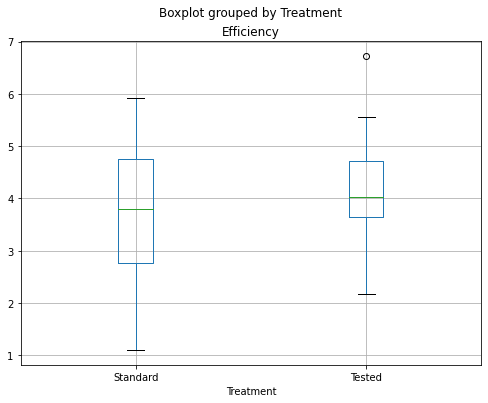

In [47]:
dataframe2.boxplot('Efficiency', by='Treatment', figsize=(8, 6))

In [48]:
def fisher(data, val_colname, grp_colname):
    print(f"\nTesting with a test of Fisher, if the mean of '{val_colname}' are the same for the different '{grp_colname}'...")
    grps = pd.unique(data[grp_colname].values)    
    k = len(grps)  # nombre de groupes
    N = len(data.values)  # nombre d'observations
    n = data.groupby(grp_colname).size() # nombre d'observations dans chaque groupe attention les groupes ne sont pas de meme taille
    # calcule la variabilite due aux interactions entre groupes (Sum of Squares Between)
    SSbetween = sum(data.groupby(grp_colname)[val_colname].mean()**2*n) - data[val_colname].mean()**2*N    
    # calcule la variabilite due aux differences entre les observations (Sum of Squares Within)
    sum_y_squared = sum([value**2 for value in data[val_colname].values])
    SSwithin = sum_y_squared - sum(data.groupby(grp_colname)[val_colname].mean()**2*n)
    # calcule la variabilite totale (Sum of Squares Total)
    SStotal = sum_y_squared - data[val_colname].mean()**2*N
    # defini les degres de liberte
    DFbetween = k - 1
    DFwithin = N - k
    DFtotal = N - 1
    # calcule la statistique de Fisher
    MSbetween = SSbetween/DFbetween
    MSwithin = SSwithin/DFwithin
    F = MSbetween/MSwithin
    #  Calcul de la p-value
    p = stats.f.sf(F, DFbetween, DFwithin)
    print(f"\tscipy.stats.f.sf, give a p-value = {p:.3f}")
    return p, F

def kruskal(data, val_colname, grp_colname):
    print(f"\nTesting with a test of Kruskal-Wallis, if the median of '{val_colname}' are the same for the different '{grp_colname}'...")
    grps = pd.unique(data[grp_colname].values)
    # Create a dict of data with grp as key
    d_data = {grp: data[val_colname][data[grp_colname] == grp] for grp in grps}
    kruskal = stats.kruskal(*d_data.values())
    stak_k, p = kruskal
    # print(f"{kruskal}")
    print(f"\tscipy.stats.kruskal, give a p-value = {p:.3f}")
    return kruskal

def fisher_and_kruskal(data, val_colname, grp_colname):
    fisher(data, val_colname, grp_colname)
    kruskal(data, val_colname, grp_colname)

fisher_and_kruskal(dataframe2, "Efficiency", "Treatment")


Testing with a test of Fisher, if the mean of 'Efficiency' are the same for the different 'Treatment'...
	scipy.stats.f.sf, give a p-value = 0.183

Testing with a test of Kruskal-Wallis, if the median of 'Efficiency' are the same for the different 'Treatment'...
	scipy.stats.kruskal, give a p-value = 0.311


En effectuant le test de Fisher et celui de Kruskal-Wallis (avec par défaut $\alpha=0.05$) sur l'efficacité (`Efficiency`) par traitement (`Treatment`). Nous trouvons dans les deux cas une p-value supérieure à $\alpha$, $p>\alpha=0.05$, nous concluons donc que les différences entre les moyennes et celles entre les médiannes ne sont pas statistiquement significatives.

En se basant sur ces données, nous ne pouvons donc pas affirmer avec une certitude supérieure à 95% que le traitement a un impact significatif sur l'efficacité des moteurs.

Avec plus de données sur ce nouveau traitement qui confirmeraient la tendance observée sur le début de vie du moteur nous pourrions peut être rendre une conclusion différente.

# Exercice 2 : 
Nous souhaitons développer une méthode de type apprentissage automatique qui quantifie en temps reel le risque de collision d'un drone avec des objets environnants.
 
Pour y arriver, nous avons embarqué 18 capteurs sur un drone en phase de test. Un expert a alors quantifié à plusieurs instants son risque de collision avec un autre objet. 
Un total de 67 observations labellisées ont été enregistrées dans le fichier `Observations_1.csv`.

Nous allons évaluer dans cet exercice si ces observations nous permettent de mettre en lien les données capteurs avec le niveau de risque. Nous allons aussi évaluer si nous aurions une bonne performance avec un sous ensemble pertinent des capteurs. Chaque capteur a en effet un poids non négligeable et à besoin d'énergie pour fonctionner, ce qui a un impact sur le temps d'utilisation du drone entre deux rechargements de ses batteries.

In [304]:
# Parsing Observation_1.csv into a pandas Dataframe
dataframe=pd.read_csv("./data/Observations_1.csv",sep=';')
dataframe.head(2)

,Feature_01,Feature_02,Feature_03,Feature_04,Feature_05,Feature_06,Feature_07,Feature_08,Feature_09,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Risk_level
0,11.6,6.4,4.3,7.2,14.4,19.26,39.32,50.00,13.040000,0.20,0.0440,-1.578984,2.209,9.02,0.26,94.285053,3.56,16.91,6
1,15.5,10.5,4.9,6.9,13.7,8.57,36.78,22.57,18.713333,0.51,0.8501,-2.497499,0.339,22.43,0.10,86.766527,7.06,-3.47,6


In [161]:
dataframe.describe()

,Feature_01,Feature_02,Feature_03,Feature_04,Feature_05,Feature_06,Feature_07,Feature_08,Feature_09,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Risk_level
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,13.249242,5.905303,4.175000,6.213636,13.234848,10.927727,29.842727,16.732424,11.107071,0.515606,0.400174,-2.978653,0.916212,15.624394,0.190000,93.618624,4.208939,1.654091,9.287879
std,4.212386,1.511803,0.926172,0.862891,1.100034,3.490314,7.262586,11.960462,3.455625,0.477964,0.649528,1.904327,0.479005,9.948518,0.081013,44.351354,1.596033,8.538005,3.711791
min,6.000000,4.300000,3.160000,4.900000,10.800000,4.860000,14.530000,5.930000,5.420000,0.010000,-0.979000,-10.828537,0.280000,5.830000,0.040000,-27.087703,1.640000,-33.000000,3.000000
25%,10.850000,4.800000,3.502500,5.600000,12.500000,8.760000,24.657500,9.177500,8.485000,0.222500,0.006725,-3.627035,0.595750,9.150000,0.130000,72.040609,2.877500,-1.755000,6.000000
50%,12.850000,5.350000,3.875000,5.900000,13.200000,10.105000,29.360000,12.545000,11.020000,0.350000,0.692650,-2.815750,0.812500,12.235000,0.190000,95.439246,4.030000,2.640000,9.000000
75%,15.075000,6.575000,4.485000,6.600000,13.950000,12.592500,35.315000,17.495000,13.025000,0.735000,0.928825,-1.666581,1.060000,18.182500,0.250000,115.495796,5.225000,7.010000,11.000000
max,26.800000,10.500000,7.000000,8.700000,15.600000,19.260000,44.360000,50.000000,19.000000,2.620000,0.998200,0.045798,2.658000,51.520000,0.400000,194.320216,9.640000,16.910000,19.000000


In [305]:
listColNames=list(dataframe.columns)

XY=dataframe.values
ColNb_Y=listColNames.index('Risk_level')

Y=XY[:,ColNb_Y].reshape((XY.shape[0],1))   #reshape is to make sure that Y is a column vector
X = np.delete(XY, ColNb_Y, 1)

listColNames.pop(ColNb_Y)     #to make it contains the column names of X only

display(f"{X.shape=}", f"{Y.shape=}")

'X.shape=(66, 18)'

'Y.shape=(66, 1)'

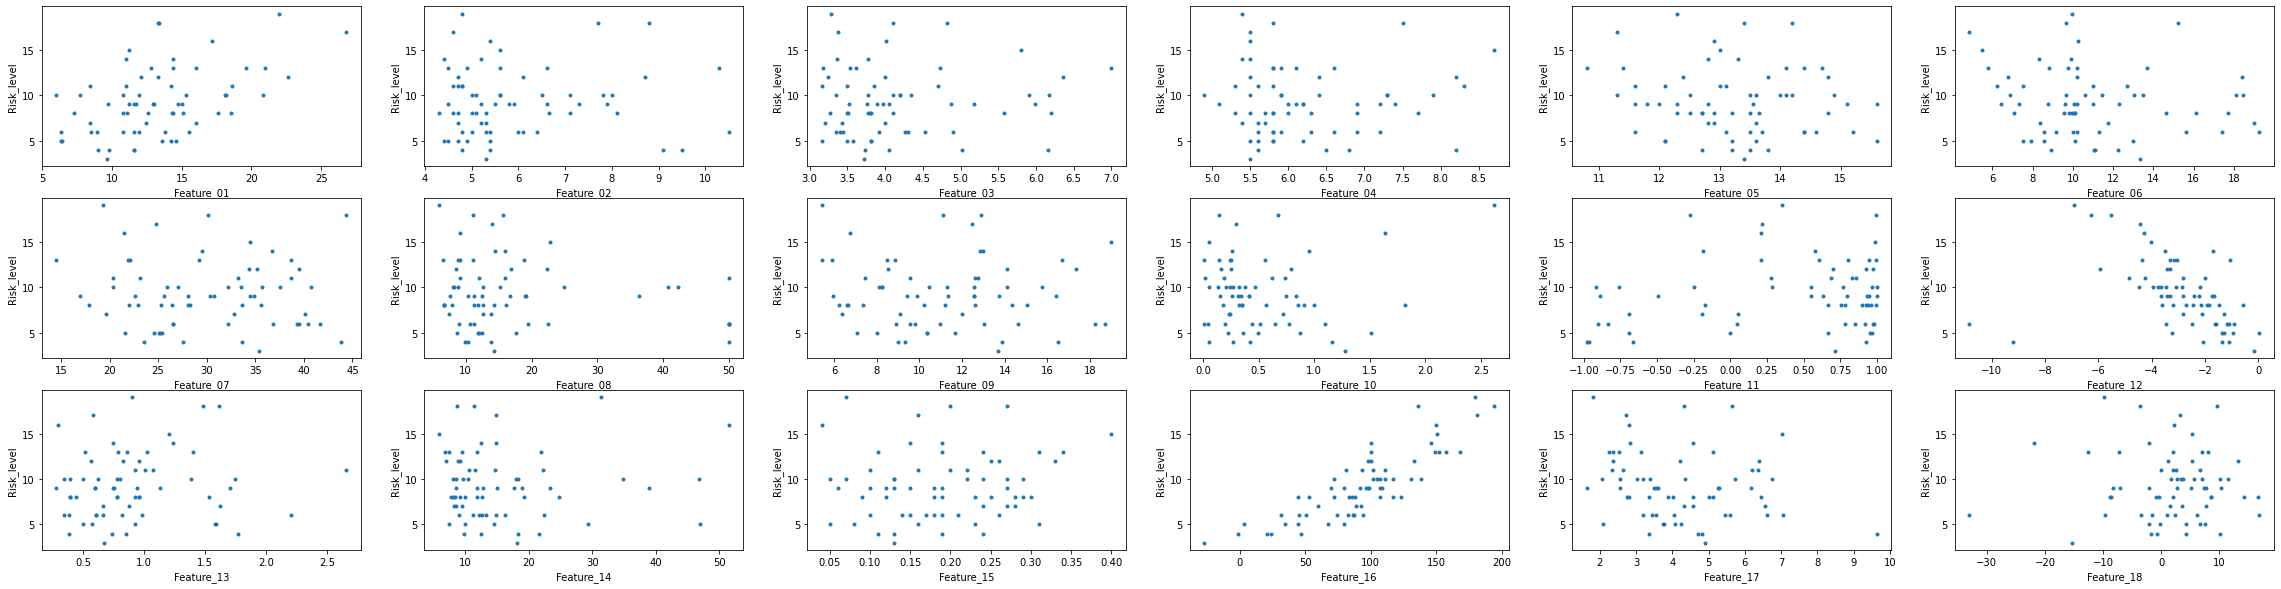

In [163]:
# Plot the data on each feature to get a first look on the link with the Risk
ncol = len(listColNames)//3 + len(listColNames)%3
fig, axs = plt.subplots(3, ncol, figsize=(40,10))
for Col in range(len(listColNames)):
    ax = axs[Col//ncol, Col%ncol]
    ax.plot(X[:,Col],Y[:],'.')
    ax.set_xlabel(listColNames[Col])
    ax.set_ylabel('Risk_level')

## QUESTION 2.1 : 
Observez les donnees unes par unes. Est-ce que vous identifiez visuellement des liens entre certaines variables et la variable 'Risk_level'. Si oui, lesquels ?

<span style="color:blue"> Il semblerait qu'il y ait un lien lineaire entre `Feature 12` et `Feature 16` et le `Risk Level`</span>

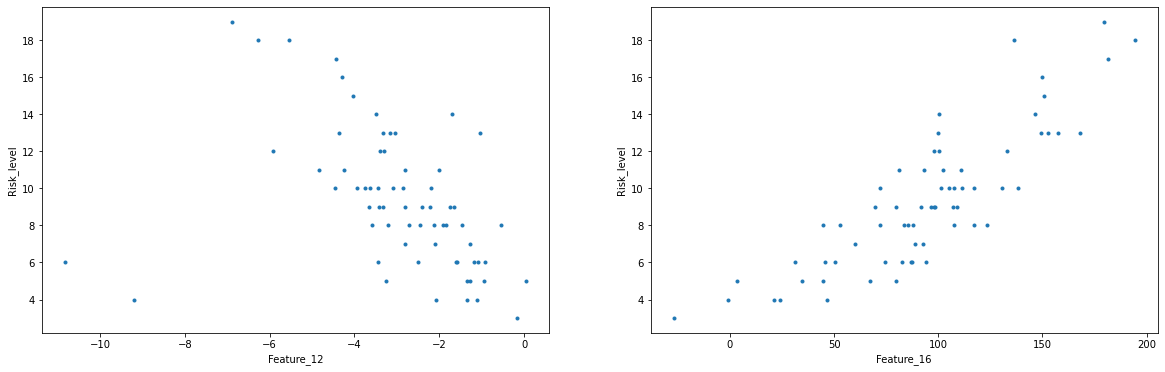

In [164]:
#  Zoom on Feature 12 and 16
fig, axs = plt.subplots(1, 2, figsize=(20,6))
for i, Col in enumerate([11,15]):
    ax = axs[i]
    ax.plot(X[:,Col],Y[:],'.')
    ax.set_xlabel(listColNames[Col])
    ax.set_ylabel('Risk_level')

## QUESTION 2.2 :  On se demande si il est possible de predire le niveau de 'Risk_level' à partir d'une seule des variables 'Feature_01', 'Feature_07' ou 'Feature_16'.

### QUESTION 2.2.1 : 
Effectuez une regression lineaire simple entre `Risk_level` et chacune de ces variables. Toutes les donnees seront utilisees. 

Evaluez alors la qualité des predictions sur toutes les donnees à l'aide de __la moyenne de l'erreur de prediction au carre (MSE)__. 

Quel est le risque potentiel en utilisant cette stratégie de validation de l'apprentissage ?

- <span style="color:blue">On risque de sur-apprendre (over-fitting) sur ce jeu de données là et de ne pas avoir un modele assez générale. Il faudrait séparer le jeu de donnés en un jeu d'apprentissage et un jeu de test pour éviter cela.</span>

Feature_01, mse=10.48, r2=0.23
Feature_07, mse=13.51, r2=0.00
Feature_16, mse=3.83, r2=0.72


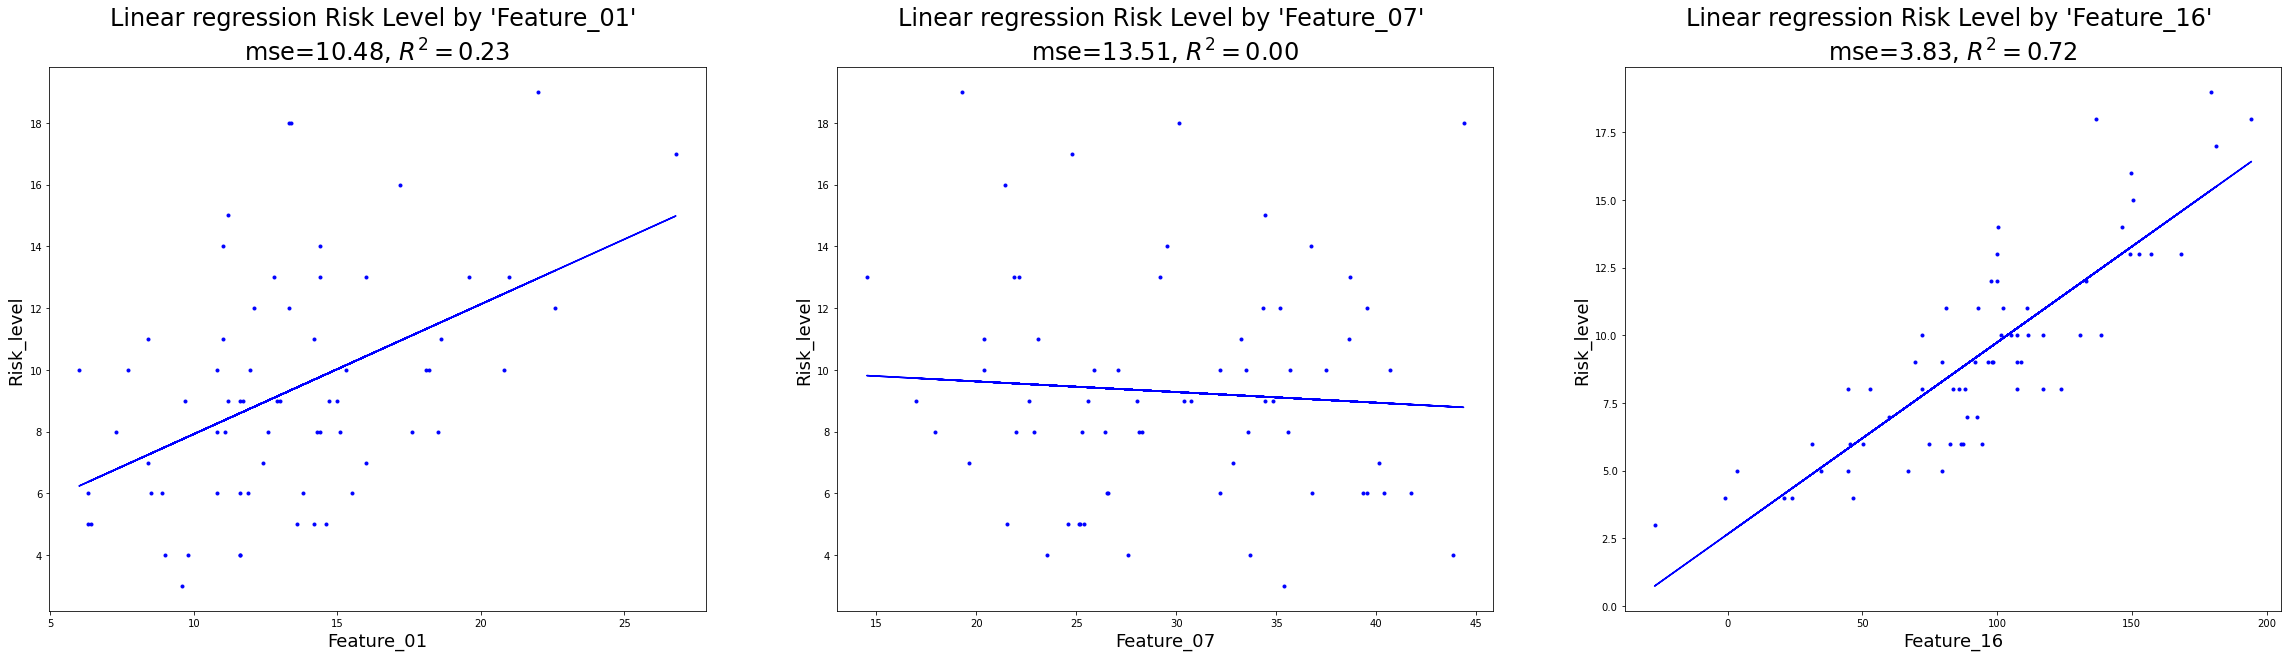

In [306]:
def lr_fit(x,y):
    lr = LinearRegression()
    lr.fit(x[:, np.newaxis], y)
    return lr

def linear_risk(X, Y, listColNames, colname, ax, bigger_font=False):
    col_index = listColNames.index(colname   )
    x = X[:, col_index]
    linear_reg(x, Y, colname, ax, bigger_font)

def linear_reg(x, y, colname, ax, bigger_font=False):
    lr = lr_fit(x, y)
    y_pred = lr.predict(x[:, np.newaxis])
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"{colname}, {mse=:.2f}, {r2=:.2f}")
    ax.plot(x,y[:],'b.')
    ax.plot(x, y_pred, 'b-')
    label_fontsize = 18 if bigger_font else 12
    ax.set_xlabel(colname, fontsize=label_fontsize)
    ax.set_ylabel('Risk_level', fontsize=label_fontsize)
    title_fontsize = 24 if bigger_font else 12
    ax.set_title(f"Linear regression Risk Level by '{colname}' \n{mse=:.2f}, $R^2={r2:.2f}$", fontsize=title_fontsize)

pred_features = ['Feature_01','Feature_07','Feature_16']
# Making the linear regression and compute the MSE on Features 1, 7 and 16
fig, axs = plt.subplots(1, len(pred_features), figsize=(40,10))
for col_index, colname in enumerate(pred_features):
    linear_risk(X, Y, listColNames, colname, axs[col_index], bigger_font=True)

D'aprés la MSE on peut voir ici que la prediction avec une régréssion lineaire est de qualité uniquement pour `Feature_16` pour les autres il ne semble pas exister de relation linéaire avec `Risk_level`

### QUESTION 2.2.2 : 
Evaluez a quel point les predictions sont stables a l'aide d'une methode de validation croisee
de type 4-folds.

In [166]:
n_splits = 4
kf = KFold(n_splits=n_splits)

for feature in [0, 6, 15]:
    sum_mse_scores=0.
    X_select = X[:, feature].reshape(-1,1)
    for train_index, test_index in kf.split(X_select):
        X_train, X_test = X_select[train_index], X_select[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)

        mse_score = mean_squared_error(y_test, y_pred)
        sum_mse_scores += mse_score
    mean = sum_mse_scores/n_splits
    print(f'Pour la Feature {feature+1}, la MSE moyenne après 4-fold vaut {mean}')

Pour la Feature 1, la MSE moyenne après 4-fold vaut 10.938813503318636
Pour la Feature 7, la MSE moyenne après 4-fold vaut 15.209387726987929
Pour la Feature 16, la MSE moyenne après 4-fold vaut 4.083669877334086


Les valeurs moyennées de MSE à l'issue du 4-fold confirment la stabilité de prediction à partir de la feature 16 et la non-qualité de prediction à partir des features
 1 et 7. Ce qui est cohérent avec les valeurs calculées précédemment.

### QUESTION 2.2.3 : 

Peut-on enfin dire si on observe une relation significative entre 'Risk_level' et (independament) 'Feature_01', 'Feature_07' ou bien 'Feature_16'. 

On peut le valider a l'aide d'un test d'hypothese dont on decrira la procedure.

D'après les résultats sur obtenu sur la MSE pour ces Features, il semble que la seul relation sigificative soit celle entre `Feature_16` et `Risk_level. 

Il faut maintenant le valider avec un test statistique.On veut tester si il existe une relation de dépendance significative entre une `Feature_X` et `Risk_level`, ce qui revient à tester si $b_1$ et significativement différent de 0 pour cette feature. 

On sait que $F = (n-2)\frac{R^2}{1-R^2}$ suit une loi de Fisher a $(1, n-2)$ degrés de liberté.

On prendra comme hypothèse $H_0: \beta_1 = 0$, qui est rejeté si $F > f_{1;n−2;1−\alpha/2}$ ou si la p-valeur associé est inférieur à $\alpha$.

In [167]:
def student(df, t_score):
    return stats.t.sf(t_score, df)*2

def std_err(x, y, y_pred):
    n = len(x)
    return math.sqrt(sum((y-y_pred)**2)/(n-2)) / math.sqrt(sum((x-x.mean())**2))

def student_pvalue(x, y, y_pred, lr):
    sb1 = std_err(x,y,y_pred)
    b1 = lr.coef_[0,0]
    t_score = abs(b1)/sb1
    df = len(x)-2
    return student(df, t_score)

def F_beta1(x,y, y_pred):
    n = len(x)
    r2 = r2_score(y, y_pred)
    return (n-2)*r2/(1-r2)

def fisher_pvalue(x, y, y_pred):
    F = F_beta1(x,y,y_pred)
    return stats.f.sf(F, 1, len(x)-2)

def test_linear_reg(x, y, colname, ax, alpha=0.05):
    print(f"\nTesting {colname}:")
    lr = lr_fit(x, y)
    y_pred = lr.predict(x[:, np.newaxis])

    p_t = student_pvalue(x ,y ,y_pred, lr)
    print(f"\tFor Student law, p-value={p_t:.2e}")
    p_F = fisher_pvalue(x,y,y_pred)
    print(f"\tFor Fisher law, p-value={p_F:.2e}")

    print(f"\tFor `{colname}` p-value={p_F:.2e} < {alpha=:.2e} ? {p_F<alpha}")


def test_linear_risk(X, Y, listColNames, colname, ax):
    col_index = listColNames.index(colname   )
    x = X[:, col_index]
    test_linear_reg(x, Y, colname, ax)

# Testing the relation between Risk and feature 1, 7, 16
for col_index, colname in enumerate(pred_features):
    test_linear_risk(X, Y, listColNames, colname, None)


Testing Feature_01:
	For Student law, p-value=5.13e-05
	For Fisher law, p-value=5.13e-05
	For `Feature_01` p-value=5.13e-05 < alpha=5.00e-02 ? True

Testing Feature_07:
	For Student law, p-value=5.91e-01
	For Fisher law, p-value=5.91e-01
	For `Feature_07` p-value=5.91e-01 < alpha=5.00e-02 ? False

Testing Feature_16:
	For Student law, p-value=3.16e-19
	For Fisher law, p-value=3.16e-19
	For `Feature_16` p-value=3.16e-19 < alpha=5.00e-02 ? True


On remarque que pour `Feature_07` $p-value>\alpha$ donc le nuage de point est réparti sans structure linéaire significative avec `Risk_level`, on accepte l'hypothèse null $b_1=0$. 

Pour les deux autres Feature (01 et 16) $p-value<\alpha$ on rejette donc l'hypothèse null $b_1=0$ et on peut dire qu'il existe une influence de la `Feature_01/16` sur `Risk_level`. 

On peut cependant remarquer que la p-value obtenue pour `Feature_16` est trés petite devant la p-value obtenue pour `Feature_01` $(3,16.10^{-19} \ll 5,13.10^{-05})$ ce qui indique que la relation avec `Risk_level` est plus certaine pour `Feature_16`.

## QUESTION 2.3 :
On s'interesse maintenant au lien entre la variable 'Risk_level' et 'Feature_12'.
On peut remarquer que ces donnees contiennent deux valeurs aberrantes.

Feature_12, mse=11.29, r2=0.17


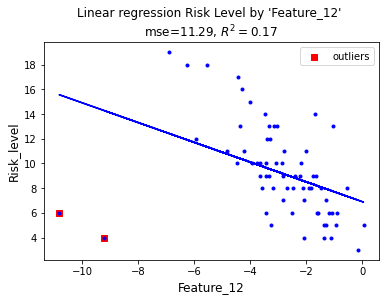

In [307]:
    Feature_12 = X[:, listColNames.index("Feature_12")]
    ax = plt.subplots()[1]
    ax.scatter(Feature_12[[29,49]], Y[[29,49]], c='red', marker='s', label='outliers')
    ax.legend()
    linear_reg(Feature_12, Y, "Feature_12", ax)
    # there is clearly some outiers in 'Feature_12'

## QUESTION 2.3.1 : 
Definissez une procedure pour detecter automatiquement deux donnees aberrantes dans un jeu de donnees.

Detecting outliers in 'Feature_12' observations for predicting 'Risk_level'
	Outlier #0 is Observation #29 with D(29)=2.076921642023367
	Outlier #1 is Observation #49 with D(49)=1.212158061191167



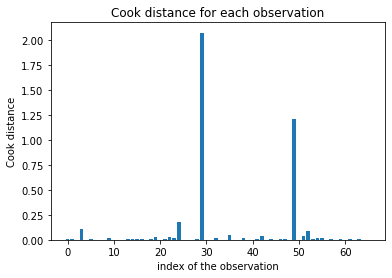

In [170]:
def cook_distances(x,y):
    n = len(x)
    lr = lr_fit(x,y)
    y_pred = lr.predict(x[:, np.newaxis])
    s2=np.sum((y-y_pred)*(y-y_pred))/(n-2)

    distances = []
    for i in range(n):
        x_del_i=np.delete(x,i)
        y_del_i=np.delete(y,i)
        lr_del_i = lr_fit(x_del_i, y_del_i)
        y_hat_pred = lr_del_i.predict(x[:, np.newaxis])

        sum_squared_error=np.sum((y_pred - y_hat_pred)*(y_pred - y_hat_pred))
        distances.append(sum_squared_error/(2.*s2))
    return distances

def detect_outliers(X, Y, nb_outliers=2):
    cookdistances = cook_distances(X,Y)
    plt.bar(list(range(len(cookdistances))), cookdistances)
    plt.title("Cook distance for each observation")
    plt.ylabel("Cook distance")
    plt.xlabel("index of the observation")

    cook_dict = {i: dist for i, dist in enumerate(cookdistances)}
    cook_dict_sorted = {k: v for k, v in sorted(cook_dict.items(), key=lambda item: item[1], reverse=True)}

    outliers = list(cook_dict_sorted.items())
    for i in range(nb_outliers):
        outlier = outliers[i]
        print(f"\tOutlier #{i} is Observation #{outlier[0]} with D({outlier[0]})={outlier[1]}")
    print()

    return cook_dict_sorted

def detect_outliers_df(df, xname="Feature_12", yname='Risk_level', nb_outliers=2):
    print(f"Detecting outliers in '{xname}' observations for predicting '{yname}'")
    return detect_outliers(df[xname].to_numpy(), df[yname].to_numpy(), nb_outliers)

outliers = detect_outliers_df(dataframe)

## QUESTION 2.3.2 : 
Nous supprimerons dans la suite de cet exercice les deux observations qui sont aberrantes sur la variable 'Feature_12'. 

Comment auriez-vous traite ces observations si vous aviez absolument voulu preserver l'information qu'elles contiennent dans les autres variables ?

- On peut remplacer les valeurs par les valeurs qui correspondent au modèle entrainé sans les outliers.

Linear model found without indexes: [29, 49] is: 
	y = [-1.88491664]x + [4.22208744]

Feature_12, mse=5.85, r2=0.57


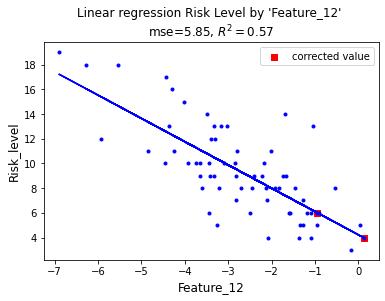

In [171]:
def delete_and_replace_outliers(x,y, indexes):
    xdel = np.array([v for i,v in enumerate(x) if i not in frozenset(indexes)])
    ydel = np.array([v for i,v in enumerate(y) if i not in frozenset(indexes)])
    
    lr_del = lr_fit(xdel, ydel)
    a = lr_del.coef_[0]
    b =lr_del.intercept_
    print(f"Linear model found without indexes: {indexes} is: \n\ty = {a}x + {b}\n")
    
    newx = np.array(x)
    for i in indexes:
        newx[i] = (y[i] -b)/a
    return newx

ax = plt.subplots()[1]
newx = delete_and_replace_outliers(Feature_12,Y, list(outliers.keys())[:2])

linear_reg(newx, Y, "Feature_12", ax)
xout = [newx[i] for i in list(outliers.keys())[:2]]
yout = [Y.flatten()[i] for i in list(outliers.keys())[:2]]
ax.scatter(xout, yout, c='red', marker='s', label='corrected value')
ax.legend()
plt.show()
# Much better now

## QUESTION 2.4 :
Une fois les deux observations aberrantes de 'Feature_12' supprimees, on souhaite selectionner les variables de 'X' qui permettent de prédire au mieux 'Risk_level' a l'aide de la regression multiple regularisee.

In [172]:
print(f"outliers 29 old observation value \t{dataframe.Feature_12[29]}")
dataframe.Feature_12.update(pd.Series(newx))
print(f"outliers 29 corrected value \t\t{dataframe.Feature_12[29]}")

# Remake X and Y np array from dataframe with Feature_12 corrected values
XY=dataframe.values
Y=XY[:,ColNb_Y].reshape((XY.shape[0],1))   #reshape is to make sure that Y is a column vector
X = np.delete(XY, ColNb_Y, 1)

outliers 29 old observation value 	-10.82853664
outliers 29 corrected value 		-0.943231397971216


## QUESTION 2.4.1 : 
Quelle strategie vous semble la plus appropriee pour selectionner les variables les plus pertinentes ? 

Quel pretraitement allez-vous de meme effectuer sur les donnees.

La régression Lasso semble appropriée pour sélectionner les variables les plus pertinentes. Il va néanmoins falloir centrer et réduire X avant d'étudier la variabilité de chacune des variables.

In [173]:
# Centre et réduit X
X = preprocessing.scale(X)


## QUESTION 2.4.2 : 
Effectuez la procedure de selection des variables optimales en parametrant a la main le poids entre la qualite de prediction et le niveau de regularisation.

In [183]:
def lasso(alpha, X_train, y_train):
    """
    return lasso_regressor, fitted on train data
    """
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X_train, y_train)
    return lasso_regressor

def lasso_and_mse(alpha, X_train, X_test, y_train, y_test):
    """
    return lasso_regressor (fitted on train data), mse (test vs pred), y_pred_lasso (for X_test)
    """
    lr = lasso(alpha, X_train, y_train)
    y_pred_lasso = lr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    return lr, mse, y_pred_lasso

def nb_betas_selected(betas, epsilon=0.3):
    """
    Return the number of beta that are in absolute value superior or equal than epsilon*max(betas)
    """
    beta_max = max([abs(b) for b in betas])
    return sum(abs(beta)/beta_max >= epsilon for beta in betas)

def betas_selected_indexes(betas, epsilon=0.3):
    """
    Return the number of beta that are superior than epsilon*max(betas)
    """
    beta_max = max([abs(b) for b in betas])
    return [i for i in range(len(betas)) if abs(betas[i])/beta_max >= epsilon]

def selected_feature_indexes(betas, epsilon=0.3):
    """
    Return the index (starting at 1) of feature selected depending on betas value
    """
    bi_selected = betas_selected_indexes(betas, epsilon)
    return list(sorted([bi + 1 for bi in bi_selected]))


In [294]:
def plot_lasso(y_test, y_pred, mse_score_lasso, alpha, betas, epsilon, figsize=(22,2.5)):
    selected_feature = selected_feature_indexes(betas, epsilon)
    nb_selected_var = len(selected_feature)
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f"Lasso with $\\alpha={alpha:.2f}$, {mse_score_lasso=:.2f}")
    ax[0].plot(y_test, y_pred, 'b.')
    ax[0].set_xlabel('True value')
    ax[0].set_ylabel('Predicted value')
    ax[0].set_title(f"True vs predicted value")
    
    ax[1].plot(range(1, len(betas)+1), [abs(b) for b in betas], 'r.')
    ax[1].set_ylabel('$|\\beta|$ éstimé')
    ax[1].set_xlabel('Feature')
    ax[1].set_xticks(range(1, len(betas)+1))
    ax[1].set_title(f"$|\\beta|$ by feature, {nb_selected_var} variables selected {selected_feature}")


On plot le graphe "True vs predicted value" et les coefficients $|\beta_i|$ pour différentes valeurs de $\alpha$ (arbitraire). On fait également apparaître la valeur de Mean Square Error et le nombre de variables sélectionnées après la régression LASSO. 

Pour ce faire, on utilise la variable `epsilon` qui fait office de seuil : les variables dont le coefficient $\beta$ est inférieur à un certain pourcentage de la valeur max des coefficients sont considérées supprimées.

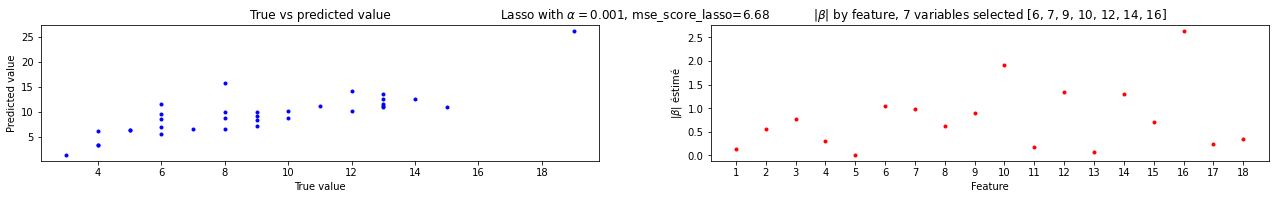

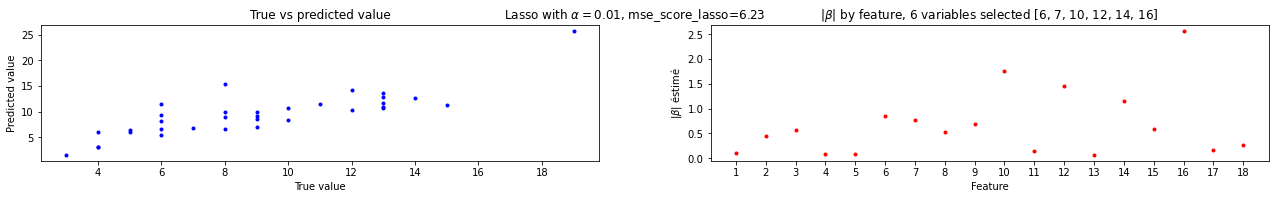

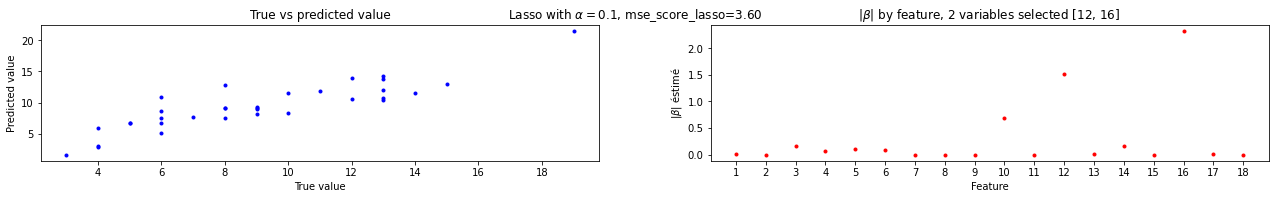

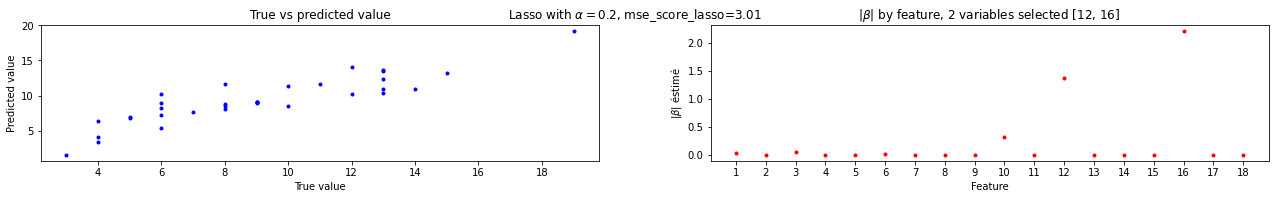

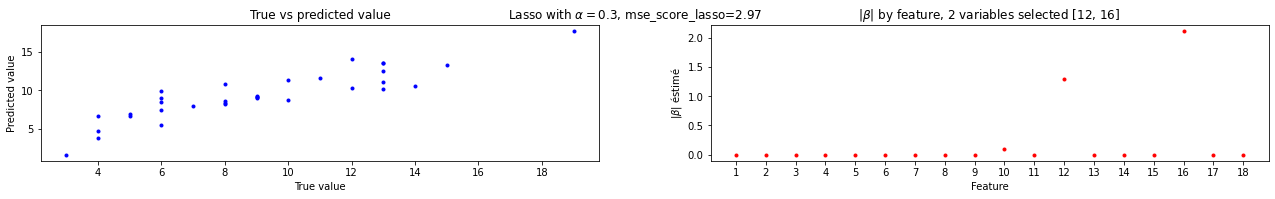

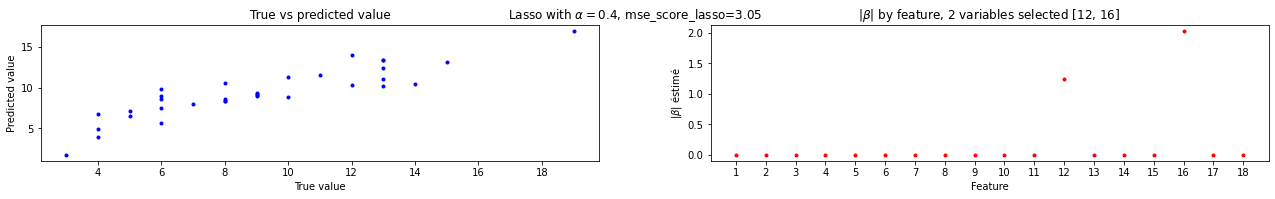

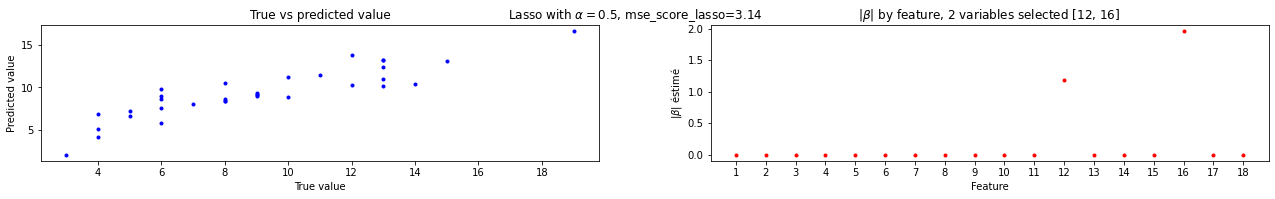

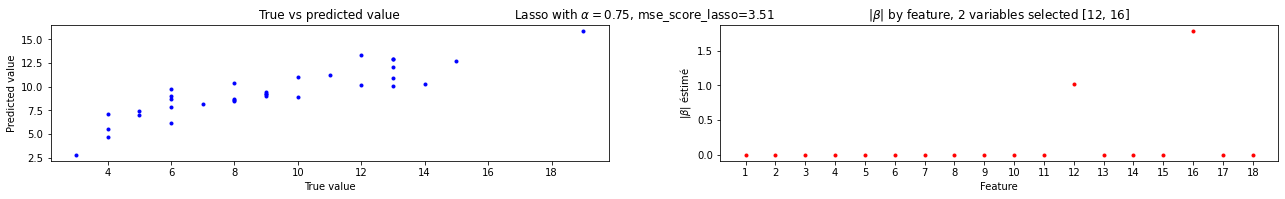

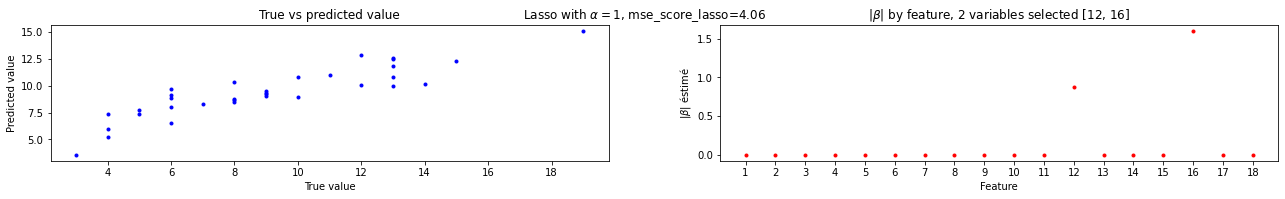

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5) # On coupe en 2 les données de test et apprentissage

alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
mse_scores_lasso = np.zeros(len(alphas))
nb_selected_vars = np.zeros(len(alphas))
selected_features = []

for index, alpha in enumerate(alphas):
    lasso_regressor , mse_score_lasso, y_pred_lasso = lasso_and_mse(alpha, X_train, X_test, y_train, y_test)
    mse_scores_lasso[index] = mse_score_lasso

    epsilon = 0.3
    betas = lasso_regressor.coef_
    selected_feature = selected_feature_indexes(betas, epsilon)
    selected_features.append(selected_feature)
    nb_selected_vars[index] = len(selected_feature)
    
    plot_lasso(y_test, y_pred_lasso, mse_score_lasso, alpha, betas, epsilon) 

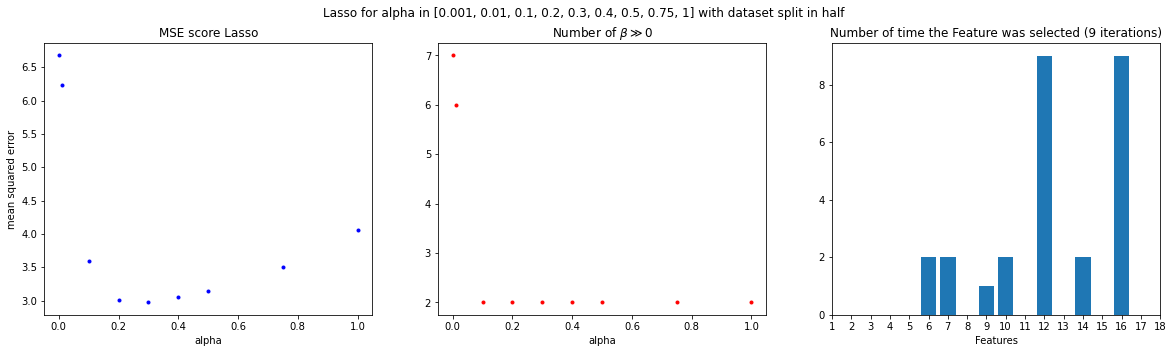

In [178]:
fig, axs= plt.subplots(1,3, figsize=(20,5))
fig.suptitle(f"Lasso for alpha in {alphas} with dataset split in half")
axs[0].plot(alphas, mse_scores_lasso, 'b.')
axs[0].set_xlabel("alpha")
axs[0].set_ylabel("mean squared error")
axs[0].set_title("MSE score Lasso")
axs[1].plot(alphas, nb_selected_vars, 'r.')
axs[1].set_xlabel("alpha")
axs[1].set_title("Number of $\\beta \\gg 0$")
occurrences = Counter([item for sublist in selected_features for item in sublist])
axs[2].bar(occurrences.keys(), occurrences.values())
axs[2].set_xlabel("Features")
axs[2].set_xticks(range(1, 19))
axs[2].set_title(f"Number of time the Feature was selected ({len(selected_features)} iterations)")
plt.show()

On observe une tendance à souvent sélectionner uniquement deux feature `12` et `16`. Et il semble exister un $\alpha$ qui minimize la MSE.

## QUESTION 2.4.3 : 
Effectuez la procedure automatique de parametrisation de ce poids, de sorte a ce q'un maximum de trois variables soit typiquement selectionne et que la qualite de prediction soit optimale.

Quelle methode de validation croisee vous semble la plus raisonnable ici ? 

La selection des variables est-elle stable ?

On utilise un seuil `epsilon` qui correpond à 20% de la valeur de `beta` max dans le but d'éliminer les betas négligeables.

In [282]:
%%time
n_iter = 1000
epsilon = 0.2
alpha_init = 0.001
alphas_opt = []
mse_mins = []
selected_features = []
iterations = []
for i in range(n_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5) # On coupe en 2 les données de test et apprentissage
    alpha_init = 0.001
    mse_alpha_func = lambda alpha : lasso_and_mse(alpha, X_train, X_test, y_train, y_test)[1]
    res = minimize(mse_alpha_func, alpha_init, method='Powell', bounds=[(0.001, 1)])
    if res.success:
        clear_output(wait=True)
        print(f"#{i} After {res.nfev} iteration, Found alpha_optim={res.x[0]:.2f} for mse={res.fun:.2f}")
        alphas_opt.append(res.x[0])
        mse_mins.append(res.fun)
        iterations.append(res.nfev)

        lasso_regressor, mse_score_lasso, y_pred_lasso = lasso_and_mse(res.x[0], X_train, X_test, y_train, y_test)
        betas = lasso_regressor.coef_
        selected_features.append(selected_feature_indexes(betas, epsilon))
clear_output(wait=True)

CPU times: user 1min 45s, sys: 885 ms, total: 1min 46s
Wall time: 1min 46s


In [283]:
def plot_feats_mse_alpha_iters(selected_features, mses, alphas, iterations, epsilon, title):
    df = pd.DataFrame({'alpha': alphas, 'mse': mses, 'iterations': iterations})
    alpha = df.alpha.mean()

    occurrences = Counter([item for sublist in selected_features for item in sublist])

    fig, axs = plt.subplots(1,4, figsize=(22,5))
    fig.suptitle(f"{len(alphas)} iterations {title}, average {alpha=:.2f}, average mse={df.mse.mean():.2f}, average nb_iterations={df.iterations.mean():.0f}")
    axs[0].bar(occurrences.keys(), occurrences.values())
    axs[0].set_xlabel("Features")
    axs[0].set_xticks(range(1, 19))
    axs[0].set_ylabel("Frequency")
    axs[0].legend(["Selected Features"])
    axs[0].set_title(f"Number of time the Feature was selected with {epsilon=}")
    df_amin.mse.plot(kind='hist', legend=True, color='orange', ax=axs[1])
    df_amin.alpha_min.plot(kind='hist', legend=True, color='green', ax=axs[2])
    df_amin.iterations.plot(kind='hist', legend=True, color='purple', ax=axs[3])

    print(f"Occurences of each Feature_X: {dict(occurrences)} \n")

Occurences of each Feature_X: {12: 987, 16: 1000, 1: 96, 17: 16, 10: 3, 2: 5, 13: 2, 8: 2, 6: 8, 15: 1, 5: 1, 7: 11, 9: 7, 11: 1, 18: 2} 



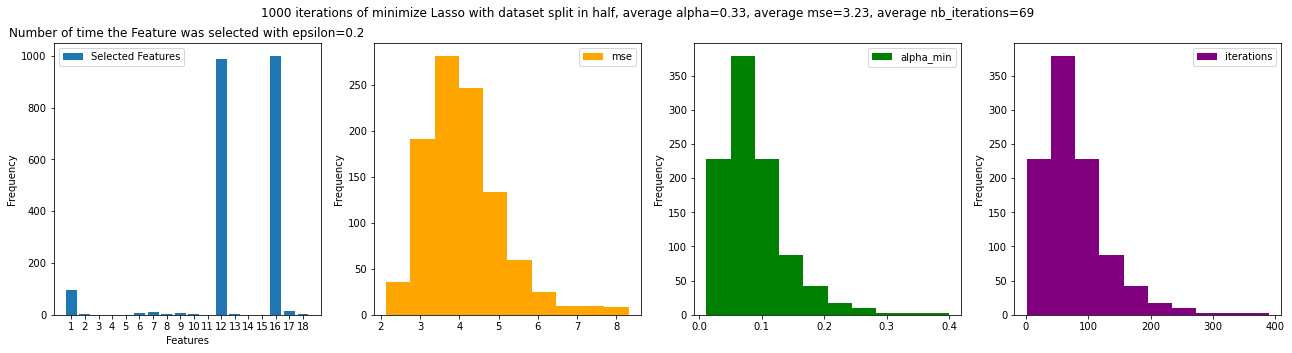

In [284]:
plot_feats_mse_alpha_iters(selected_features, mse_mins, alphas_opt, iterations, epsilon, "of minimize Lasso with dataset split in half")

### Une autre idée pour sélectionner le alpha optimal pourrait être de chercher le premier alpha qui selectionne au plus 3 variables

In [285]:
def search_min_alpha(alpha_init, step_alpha, X, Y, **kwargs):
    """
    METHODE INCREMENTALE du alpha jusqu'a ce qu'il ne reste plus que nb_var_max beta non considéré nuls
    """
    verbose = kwargs.get('verbose',False)
    epsilon = kwargs.get('epsilon',0.2)
    nb_var_max = kwargs.get('nb_var_max',3)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5) # On coupe en 2 les données de test et apprentissage

    alpha = alpha_init
    nb_selected_var = X.shape[1]
    selected_features = []
    iters = 0
    while nb_selected_var > nb_var_max:
        lasso_regressor , mse_score_lasso, y_pred_lasso = lasso_and_mse(alpha, X_train, X_test, y_train, y_test)
        betas = lasso_regressor.coef_
        selected_features = selected_feature_indexes(betas, epsilon)
        nb_selected_var = len(selected_features)
        alpha += step_alpha
        iters+=1

    alpha_min = alpha
    if verbose: print(f"After {iters} iteration, found {alpha_min=:.4f}, Selected Features: {selected_features}")
    return alpha_min, mse_score_lasso, selected_features, iters

In [286]:
%%time
epsilon = 0.2
step_alpha = 0.001
alpha_init = 0.01 # d'apres les dernieres simulations 

alpha_mins = []
mses = []
selected_features = []
iterations = []
for i in range(n_iter):
    clear_output(wait=True)
    a_min, mse, feats, iters = search_min_alpha(alpha_init, step_alpha, X, Y, epsilon=0.2, nb_var_max=3)
    alpha_mins.append(a_min)
    mses.append(mse)
    selected_features.append(feats)
    iterations.append(iters)
    print(f"#{i} After {iters} iteration, Found alpha_min={a_min:.2f} for mse={mse:.2f}")
clear_output(wait=True)
print("Finished !")

Finished !
CPU times: user 1min 54s, sys: 603 ms, total: 1min 54s
Wall time: 1min 56s


Occurences of each Feature_X: {8: 78, 12: 972, 16: 1000, 7: 172, 9: 45, 1: 210, 17: 101, 13: 39, 11: 7, 2: 87, 10: 73, 18: 37, 14: 26, 5: 10, 15: 8, 6: 62, 4: 31, 3: 25} 



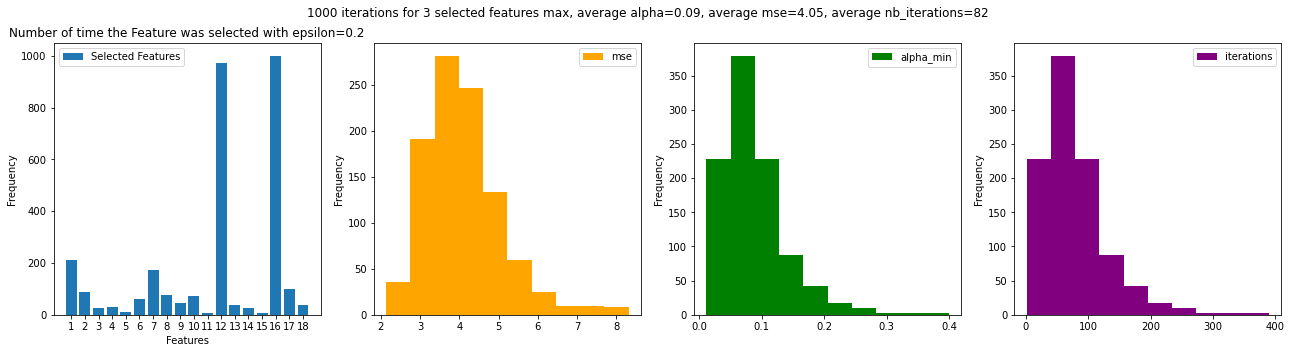

In [287]:
plot_feats_mse_alpha_iters(selected_features, mses, alpha_mins, iterations, epsilon, "for 3 selected features max")

In [292]:
alpha_opt = pd.Series(alphas_opt).mean()
alpha_min = pd.Series(alpha_mins).mean()
print(f"After {n_iter} iterations we found that on average:")
print(f"\t- alpha that minimize the MSE is {alpha_opt:.2f} for an average mse={pd.Series(mse_mins).mean():.2f}")
print(f"\t- alpha for 3 variables max is {alpha_min:.2f} for an average mse={pd.Series(mses).mean():.2f}")

After 1000 iterations we found that on average:
	- alpha that minimize the MSE is 0.33 for an average mse=3.23
	- alpha for 3 variables max is 0.09 for an average mse=4.05


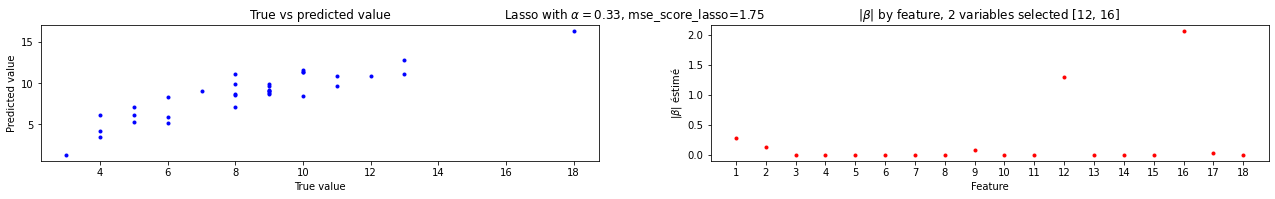

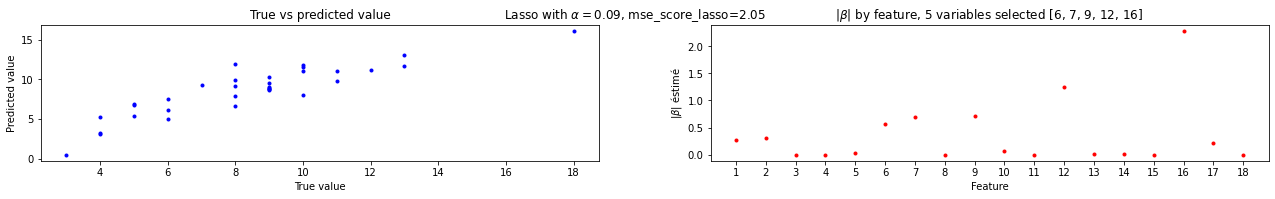

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5) # On coupe en 2 les données de test et apprentissage
# Plotting Lasso for the alpha optimum found
lasso_regressor , mse_score_lasso, y_pred_lasso = lasso_and_mse(alpha_opt, X_train, X_test, y_train, y_test)
betas = lasso_regressor.coef_
plot_lasso(y_test, y_pred_lasso, mse_score_lasso, alpha_opt, betas, epsilon) 
# Plotting Lasso for the average min alpha found
lr , mse, y_pred = lasso_and_mse(alpha_min, X_train, X_test, y_train, y_test)
betas_min = lr.coef_
plot_lasso(y_test, y_pred, mse, alpha_min, betas_min, epsilon) 

On choisie de garder le `alpha_opt` obtenu en minimisant la MSE, car il donne lui aussi au plus trois variables mais avec une meilleur prédiction.

### Quelle methode de validation croisee vous semble la plus raisonnable ici ? 

On effectue de nouveau un K-fold pour la cross-validation, avec `n_splits=4`, `epsilon=0.2`

In [300]:
%%time
def k_fold_with_lasso_print(X, Y, n_splits, alpha, **kwargs):
    verbose = kwargs.get('verbose',False)
    epsilon = kwargs.get('epsilon',0.2)
    selected_features = []
    kf = KFold(n_splits=n_splits, shuffle=True)
    sum_mse_scores=0.
    if verbose: print("Selected Features: ", end="")
    for train_index, test_index in kf.split(X):
        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        # Make Lasso regression
        lasso_regressor , mse_score_lasso, y_pred_lasso = lasso_and_mse(alpha, X_train, X_test, y_train, y_test)
        sum_mse_scores += mse_score_lasso

        betas = lasso_regressor.coef_
        selected_features.append(selected_feature_indexes(betas, epsilon))
        # Print feature selected
        if verbose: print(f"{selected_features}", end=", ")

    mean = sum_mse_scores/n_splits
    if verbose: print(f'\nLa MSE moyenne après {n_splits}-fold vaut {mean:.3f}\n')
    return selected_features, mean

selected_features = []
mse_means = []
epsilon = 0.2
n_splits = 4
for i in range(1000):
    clear_output(wait=True)
    list_feats, mean_mse = k_fold_with_lasso_print(X, Y, n_splits, alpha_opt, epsilon=epsilon, verbose=False)
    for feats in list_feats: selected_features.append(feats)
    mse_means.append(mean_mse)
    print(f"#{i}: {mean_mse=:.2f}")
clear_output(wait=True)
print("Finished !")

Finished !
CPU times: user 11.2 s, sys: 576 ms, total: 11.8 s
Wall time: 13.4 s


Occurences of each Feature_X: {12: 4000, 16: 4000, 1: 55}


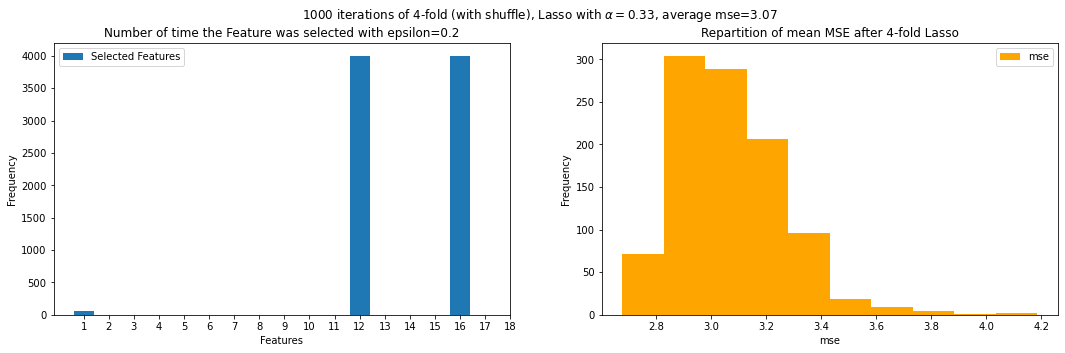

In [301]:
occurrences = Counter([item for sublist in selected_features for item in sublist])
mean_mse_S = pd.Series(mse_means)

fig, axs = plt.subplots(1,2, figsize=(18,5))
fig.suptitle(f"{len(mse_means)} iterations of {n_splits}-fold (with shuffle), Lasso with $\\alpha={alpha_opt:.2f}$, average mse={mean_mse_S.mean():.2f}")
axs[0].bar(occurrences.keys(), occurrences.values())
axs[0].set_xlabel("Features")
axs[0].set_xticks(range(1, 19))
axs[0].set_ylabel("Frequency")
axs[0].legend(["Selected Features"])
axs[0].set_title(f"Number of time the Feature was selected with {epsilon=}")

axs[1].set_xlabel("mse")
mean_mse_S.plot(kind='hist', label='mse', legend=True, color='orange', title=f"Repartition of mean MSE after {n_splits}-fold Lasso", ax=axs[1])

print(f"Occurences of each Feature_X: {dict(occurrences)}")

### La selection des variables est-elle stable ?

La selection des variables est très stable. En fixant le seuil à 20% de la valeur de beta max, on observe que les variables sélectionnées sont presque exclusivement au nombre de 2 et au maximum au nombre de 3. On remarque que les deux variables qui appairaissent le plus sont la Feature 16, et la Feature 12.

On observe parfois également la Feature 1,dont le beta associé dépasse le seuil fixé par rapport à la valeur de beta max, pour certain split des données.